A while ago I did a blog post with an [introduction to stereo groups and enhanced stereochemistry](https://greglandrum.github.io/rdkit-blog/posts/2023-11-19-explaining-stereo-groups.html). The basic idea of enhanced stereo isn't particularly complicated, but interpreting what a given enhanced stereo specification with more than one stereo group actually means can be decidedly non-trivial. I've had a few conversations about this recently, so it seemed like a good idea to write some code.

In this post I provide some tools that are intended to help interpret enhanced stereo specifications. The idea is to expand the specification in a molecule and provides information about what it actually means.

For example, for this molecule from the previous blog post:
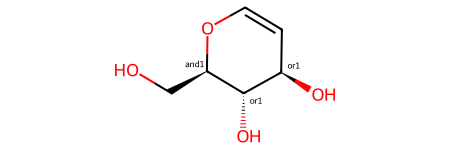
you get this set of possible stereoisomers:
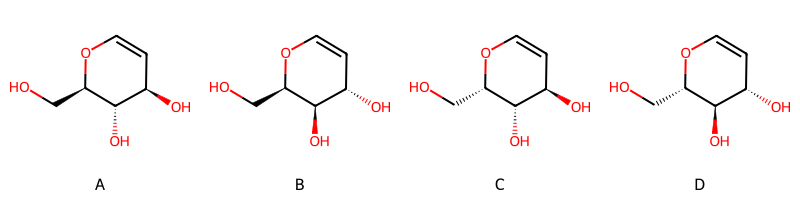
and this summary of what's present: `['AND', ['OR', 'A', 'B'], ['OR', 'C', 'D']]`.
So the enhanced stereo spec is saying that you have stereoisomer A or B together with stereoisomer C or D.

I think this code is useful enough to people working with enhanced stereo that it should probably end up in the RDKit, but I wanted to first get it out there and collect some feedback on whether or not people agree that I'm doing everything correctly and that the format of the results looks reasonable.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import EnumerateStereoisomers

import rdkit
print(rdkit.__version__)

2024.09.4


Start with a molecule with a single stereo group containing a single atom:

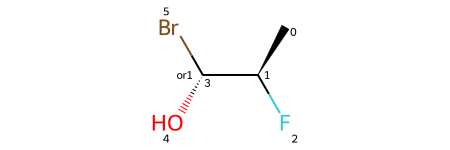

In [2]:
IPythonConsole.drawOptions.addAtomIndices = True
m = Chem.MolFromSmiles('C[C@@H](F)[C@H](O)Br |o1:3|')
m

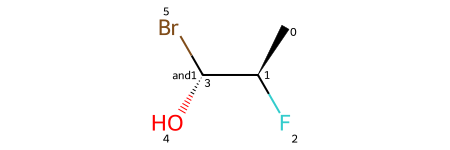

In [3]:
mAnd = Chem.MolFromSmiles('C[C@@H](F)[C@H](O)Br |&1:3|')
mAnd

In this case it works fine to just run `EnumerateStereoisomers()` and then look at the type - `AND` or `OR` - of the stereogropu:

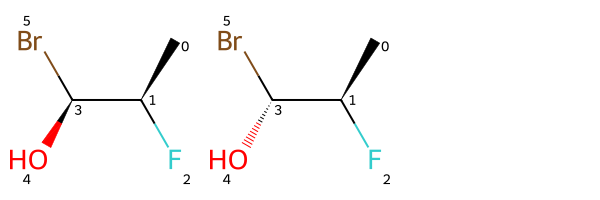

In [4]:
opts = EnumerateStereoisomers.StereoEnumerationOptions()

ms = EnumerateStereoisomers.EnumerateStereoisomers(m,options=opts)
Draw.MolsToGridImage(list(ms))

In [5]:
sgs = m.GetStereoGroups()
sg0 = sgs[0]
sg0.GetGroupType(),[x.GetIdx() for x in sg0.GetAtoms()]

(rdkit.Chem.rdchem.StereoGroupType.STEREO_OR, [3])

`EnumerateStereoisomers()` will enumerate all stereoisomers of a molecule, but we need more fine-grained control than that for this work, so here's an function to enumerate all stereoisomers covered by a single stereogroup.

In [6]:
def _invertAtomStereochemistry(atom):
    chi = atom.GetChiralTag()
    if chi==Chem.ChiralType.CHI_TETRAHEDRAL_CCW:
        nchi = Chem.ChiralType.CHI_TETRAHEDRAL_CW
    elif chi==Chem.ChiralType.CHI_TETRAHEDRAL_CW:
        nchi = Chem.ChiralType.CHI_TETRAHEDRAL_CCW
    else:
        raise ValueError('unhandled chirality')
    atom.SetChiralTag(nchi)

# not useful until 2025.03.2 release
# def _invertBondStereochemistry(bond):
#     chi = bond.GetStereo()
#     if chi==Chem.BondStereo.STEREOATROPCW:
#         nchi = Chem.BondStereo.STEREOATROPCCW
#     elif chi==Chem.BondStereo.STEREOATROPCCW:
#         nchi = Chem.BondStereo.STEREOATROPCW
#     else:
#         raise ValueError('unhandled chirality')
#     bond.SetStereo(nchi)
    
    
def enumStereogroup(m,sg):
    assert sg.GetGroupType() in (Chem.StereoGroupType.STEREO_OR, Chem.StereoGroupType.STEREO_AND)
    assert len(sg.GetAtoms()) # or len(sg.GetBonds())
    res = [sg.GetGroupType(),Chem.RWMol(m),Chem.RWMol(m)]
    for at in sg.GetAtoms():
        _invertAtomStereochemistry(res[2].GetAtomWithIdx(at.GetIdx()))
    # this will not work until v2025.03.2 is out
    #for bnd in sg.GetBonds():
    #    _invertBondStereochemistry(res[2].GetBondWithIdx(at.GetIdx()))
    
    # remove the stereogroup from the result mols
    for nmol in (res[1],res[2]):
        nsgs = []
        for nsg in nmol.GetStereoGroups():
            if nsg.GetReadId() != sg.GetReadId() or sg.GetGroupType() != nsg.GetGroupType():
                nsgs.append(nsg)
        nmol.SetStereoGroups(nsgs)
    return res

Apply that to the single stereo group from our sample molecule:

STEREO_OR


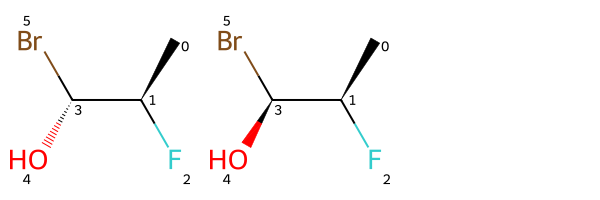

In [7]:
t = enumStereogroup(m,m.GetStereoGroups()[0])
print(t[0])
Draw.MolsToGridImage(t[1:])

If there are multiple stereo groups in a molecule, we need to decide in which order they are going to be enumerated. I haven't found anything in the CTAB documentation about what should be done, so I'm going to adopt the convention that lower numbered stereo groups have higher precedence and that `OR` is higher precedence than `AND`. The first part of this just seems logical, and the second is consistent with how Python and C++ do things: `A and B or C` is interpreted as `A and (B or C)`.

Start by establishing that 
`STEREO_OR` will sort lower than `STEREO_AND`:

In [8]:
assert Chem.StereoGroupType.STEREO_OR < Chem.StereoGroupType.STEREO_AND

Ok, that works, so here's the function for sorting stereo groups:

In [9]:
def orderStereogroups(m):
    res = [(sg.GetReadId(),sg.GetGroupType(),sg) for sg in m.GetStereoGroups()]
    return list(sorted(res))
    

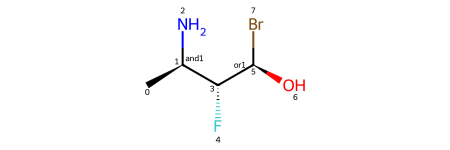

In [10]:
m2 =Chem.MolFromSmiles('C[C@@H](N)[C@@H](F)[C@H](O)Br |o1:5,&1:1|')
m2

See that we get the expected order of OR and AND:

In [11]:
orderStereogroups(m2)

[(1,
  rdkit.Chem.rdchem.StereoGroupType.STEREO_OR,
  <rdkit.Chem.rdchem.StereoGroup at 0x117dbed50>),
 (1,
  rdkit.Chem.rdchem.StereoGroupType.STEREO_AND,
  <rdkit.Chem.rdchem.StereoGroup at 0x117dbe6c0>)]

And now we can write the function to actually enumerate all stereoisomers described by a set of stereo groups.

The result is returned as a tree represented by set of nested lists:

In [12]:
def _compositionHelper(res,sgs):
    assert len(res) == 3
    if not sgs:
        return res
    nres = [res[0]]
    sg = sgs.pop(0)[2]
    for m in res[1:3]:
        nres.append(_compositionHelper(enumStereogroup(m,sg),sgs[:]))
    
    return nres

def getPossibleCompositions(m):
    # get all the AND and OR stereo groups
    sgs = [sg for sg in orderStereogroups(m) if sg[1] in (Chem.StereoGroupType.STEREO_OR, Chem.StereoGroupType.STEREO_AND)]
    if not sgs:
        raise ValueError("no enumerable stereo groups")
    res = enumStereogroup(m,sgs[0][2])
    sgs.pop(0)
    return _compositionHelper(res,sgs)

In [13]:
getPossibleCompositions(m2)

[rdkit.Chem.rdchem.StereoGroupType.STEREO_OR,
 [rdkit.Chem.rdchem.StereoGroupType.STEREO_AND,
 [rdkit.Chem.rdchem.StereoGroupType.STEREO_AND,

Finally, it would be nice useful to get a report of what could actually be in the sample.

For this we will keep track of all the unique stereoisomers present and assign each of them a letter:

In [14]:
def _treeHelper(c1,smisSeen):
    molDict = {}
    if isinstance(c1,list):
        c1, _ = list(annotateTree(c1,smisSeen))
    else:
        smi = Chem.MolToSmiles(c1)
        if smi in smisSeen:
            idx = smisSeen.index(smi)
        else:
            idx = len(smisSeen)
            smisSeen.append(smi)
        label = chr(ord('A')+idx)
        molDict[label] = c1
        c1 = (label,smi,c1)
    return c1, molDict

def annotateTree(composition,smisSeen=None):
    if smisSeen is None:
        smisSeen = []
    op,c1,c2 = composition
    c1, molDict1 = _treeHelper(c1,smisSeen)
    c2, molDict2 = _treeHelper(c2,smisSeen)
    molDict = molDict1 | molDict2
    return (op,c1,c2), molDict

In [15]:
annotateTree(getPossibleCompositions(mAnd))    

((rdkit.Chem.rdchem.StereoGroupType.STEREO_AND,
  ('A', 'C[C@@H](F)[C@H](O)Br', <rdkit.Chem.rdchem.RWMol at 0x117e11120>),
  ('B', 'C[C@@H](F)[C@@H](O)Br', <rdkit.Chem.rdchem.RWMol at 0x117e111c0>)),
 {'A': <rdkit.Chem.rdchem.RWMol at 0x117e11120>,
  'B': <rdkit.Chem.rdchem.RWMol at 0x117e111c0>})

And here's a function to generate a text description of what could be present, along with a rendering of the individual stereoisomers involved:

In [16]:
def _textSummary(composition):
    op,c1,c2 = composition
    
    if op==Chem.StereoGroupType.STEREO_AND:
        op = 'AND'
    elif op==Chem.StereoGroupType.STEREO_OR:
        op = 'OR'
    else:
        raise ValueError(op)
    
    children = []
    for c in (c1,c2):
        if isinstance(c,list):
            nc1 = _textSummary(c)
        else:
            nc1 = c[0]
        children.append(nc1)
    nc1,nc2 = children
    res = [op, nc1, nc2]
    # condense when possible
    for o in ('AND','OR'):
        if op==o and \
           isinstance(nc1,list) and nc1[0]==o and \
           isinstance(nc2,list) and nc2[0]==o:
            children = nc1[1:]
            for c in nc2[1:]:
                if c not in children:
                    children.append(c)
            res = [o] + children
            break
    return res

In [17]:
def _stereo_rows(textSummary):
    rows = []
    for index, item in enumerate(textSummary):
        if isinstance(item,list):
            pass
            # rows.append(_stereo_rows(item)) # Try out
        else:
            if item == 'AND':
                if isinstance(item[0],list):
                    pass
                    # rows.append(_stereo_rows(item[0])) # Try out
                else:
                    row = textSummary[index+1:]
                    rows.append(row)
    return rows

In [18]:
def report(composition):
    smiKey = []
    aTree, molDict = annotateTree(composition,smiKey)
    print(f'{aTree=}')
    rpt = _textSummary(aTree)
    print(f'{rpt=}')
    rows = _stereo_rows(rpt)
    print(f'{rows=}')
    # Create rows into molsMatrix where each sub-item in rows is a mol, using molDict
    molsMatrix = [[molDict[item] for item in row] for row in rows]
    print(f'{molsMatrix=}')
    img = Draw.MolsMatrixToGridImage(molsMatrix,
                                     legendsMatrix=rows,
                                     )
    print(f'{rpt=}')
    
    return rpt,img

In [19]:
IPythonConsole.drawOptions.addAtomIndices = False
rpt,img = report(getPossibleCompositions(m2))
# rpt,img = report(getPossibleCompositions(mAnd))
img

aTree=(rdkit.Chem.rdchem.StereoGroupType.STEREO_OR, (rdkit.Chem.rdchem.StereoGroupType.STEREO_AND, ('A', 'C[C@@H](N)[C@@H](F)[C@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x117e12890>), ('B', 'C[C@H](N)[C@@H](F)[C@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x117e10a40>)), (rdkit.Chem.rdchem.StereoGroupType.STEREO_AND, ('C', 'C[C@@H](N)[C@@H](F)[C@@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x117e12bb0>), ('D', 'C[C@H](N)[C@@H](F)[C@@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x117dedfd0>)))
rpt=['OR', rdkit.Chem.rdchem.StereoGroupType.STEREO_AND, rdkit.Chem.rdchem.StereoGroupType.STEREO_AND]
rows=[]
molsMatrix=[]


ValueError: max() arg is an empty sequence

So, in words, molecule `m2` contains either a mixture of A and B or a mixture of C and D.

I'm sure someone better at front-end work than I am could come up with a much nicer way of presenting this, but I think it's already useful as is.

Let's look at some more examples:

As discussed in the earlier blog post, one of the common uses of enhanced stereo is to express the relative stereochemistry of two centers.

Here's another molecule with one stereo group including two atoms (the relative stereo of those atoms is defined) and one with a single atom:

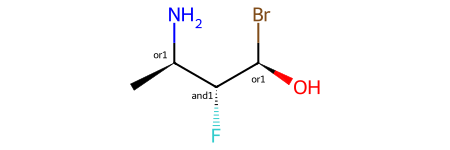

In [ ]:
m3 = Chem.MolFromSmiles('C[C@@H](N)[C@@H](F)[C@H](O)Br |o1:5,1,&1:3|')
m3

Generate a report for that:

In [ ]:
rpt,img = report(getPossibleCompositions(m3))
print(rpt)
img

aTree=(rdkit.Chem.rdchem.StereoGroupType.STEREO_OR, [(rdkit.Chem.rdchem.StereoGroupType.STEREO_AND, ('A', 'C[C@@H](N)[C@@H](F)[C@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x13627d1c0>), ('B', 'C[C@@H](N)[C@H](F)[C@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x13627d4e0>)), {'A': <rdkit.Chem.rdchem.RWMol object at 0x13627d1c0>, 'B': <rdkit.Chem.rdchem.RWMol object at 0x13627d4e0>}], [(rdkit.Chem.rdchem.StereoGroupType.STEREO_AND, ('C', 'C[C@H](N)[C@@H](F)[C@@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x13627d620>), ('D', 'C[C@H](N)[C@H](F)[C@@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x13627d440>)), {'C': <rdkit.Chem.rdchem.RWMol object at 0x13627d620>, 'D': <rdkit.Chem.rdchem.RWMol object at 0x13627d440>}])


ValueError: not enough values to unpack (expected 3, got 2)

The reporting function above will condense nested AND or OR groups. For example,
`[AND [AND A B] [AND C D]]` is reported as `[AND A B C D]`.
Here's an example of that:

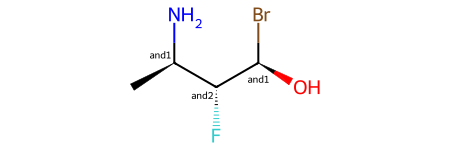

In [ ]:
m4 = Chem.MolFromSmiles('C[C@@H](N)[C@@H](F)[C@H](O)Br |&1:5,1,&2:3|')
m4

In [ ]:
rpt,img = report(getPossibleCompositions(m4))
print(rpt)
img

aTree=(rdkit.Chem.rdchem.StereoGroupType.STEREO_AND, [(rdkit.Chem.rdchem.StereoGroupType.STEREO_AND, ('A', 'C[C@@H](N)[C@@H](F)[C@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x137005080>), ('B', 'C[C@@H](N)[C@H](F)[C@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x13627d5d0>)), {'A': <rdkit.Chem.rdchem.RWMol object at 0x137005080>, 'B': <rdkit.Chem.rdchem.RWMol object at 0x13627d5d0>}], [(rdkit.Chem.rdchem.StereoGroupType.STEREO_AND, ('C', 'C[C@H](N)[C@@H](F)[C@@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x137005170>), ('D', 'C[C@H](N)[C@H](F)[C@@H](O)Br', <rdkit.Chem.rdchem.RWMol object at 0x137005260>)), {'C': <rdkit.Chem.rdchem.RWMol object at 0x137005170>, 'D': <rdkit.Chem.rdchem.RWMol object at 0x137005260>}])


ValueError: not enough values to unpack (expected 3, got 2)

At some point it may be worth adding another function which can, in the case of OR groups, provide a list of possible compositions.

This would map something like:

`['OR', ['AND', 'A', 'B'], ['AND', 'C', 'D']]`

to

```
  'A' AND 'B'
OR
  'C' AND 'D'
```

And it would also ideally be able to recognize that:
`['AND', ['OR', 'A', 'B'], ['OR', 'C', 'D']]`
is:

```
  'A' AND 'C'
OR
  'A' AND 'D'
OR
  'B' AND 'C'
OR
  'B' AND 'D'
```




Finally, here's the "more complicated" example from the original blog post:

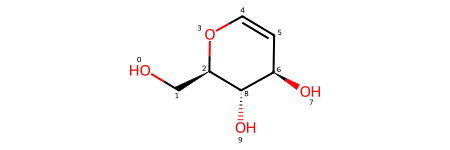

In [ ]:
IPythonConsole.drawOptions.addAtomIndices = True
Chem.MolFromSmiles('OC[C@H]1OC=C[C@@H](O)[C@@H]1O') 

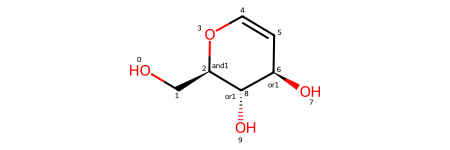

In [ ]:
IPythonConsole.drawOptions.addAtomIndices = True
three_centers = Chem.MolFromSmiles('OC[C@H]1OC=C[C@@H](O)[C@@H]1O |&1:2,o2:6,8|') 
three_centers

aTree=(rdkit.Chem.rdchem.StereoGroupType.STEREO_AND, [rdkit.Chem.rdchem.StereoGroupType.STEREO_OR, ('A', 'OC[C@H]1OC=C[C@@H](O)[C@@H]1O', <rdkit.Chem.rdchem.RWMol object at 0x14e232d40>), ('B', 'OC[C@H]1OC=C[C@H](O)[C@H]1O', <rdkit.Chem.rdchem.RWMol object at 0x14e245bc0>)], [rdkit.Chem.rdchem.StereoGroupType.STEREO_OR, ('C', 'OC[C@@H]1OC=C[C@@H](O)[C@@H]1O', <rdkit.Chem.rdchem.RWMol object at 0x14e267ab0>), ('D', 'OC[C@@H]1OC=C[C@H](O)[C@H]1O', <rdkit.Chem.rdchem.RWMol object at 0x137d33f10>)])
lblsMatrix=[['Stereoisomers', 'A', 'B', 'C', 'D']]
rpt=['AND', ['OR', 'A', 'B'], ['OR', 'C', 'D']]
['AND', ['OR', 'A', 'B'], ['OR', 'C', 'D']]


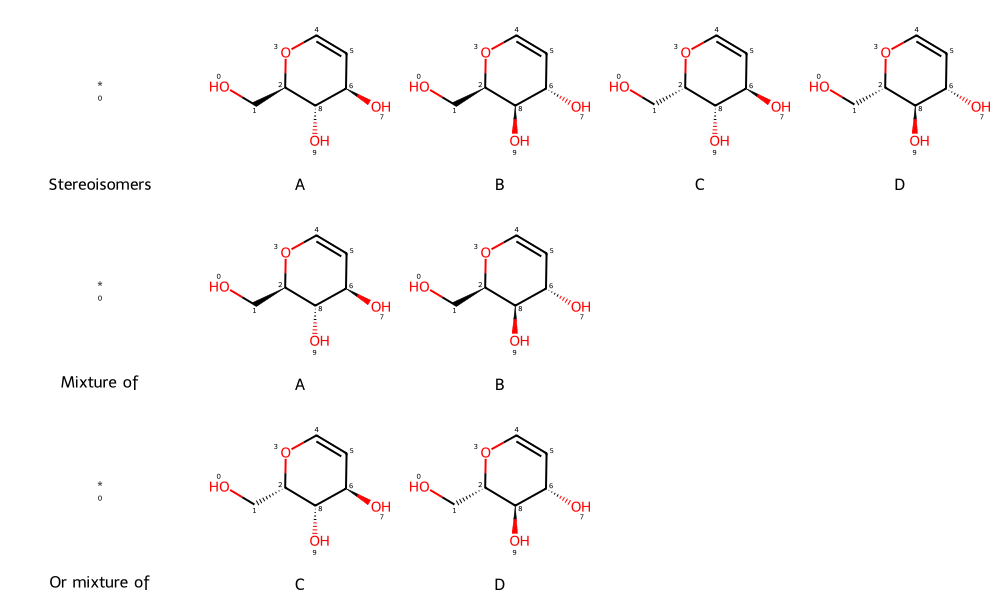

In [ ]:
rpt,img = report(getPossibleCompositions(three_centers))
print(rpt)
img